# Import

Import some useful libraries. 

In [1]:
import netket as nk
import netket.experimental as nkx
import netket.nn as nknn
import jax.numpy as jnp
from jax import grad, vmap, value_and_grad
import jax
import flax.linen as nn
import numpy as np
import matplotlib.pyplot as plt
from netket.operator.spin import sigmax,sigmaz 
from tqdm import tqdm
from scipy.sparse.linalg import eigsh
import matplotlib
import matplotlib.pyplot as plt

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica",
    "font.size": 28})

from netket.utils.types import NNInitFunc
from typing import Union, Any
from scipy.sparse.linalg import spsolve
import scipy.sparse
from matplotlib import collections as matcoll
import time


# Hamiltonian (TFIM)

We set the parameters used in the notebook. 

In [2]:
N = 8                   # number of spins
Ns = 512                # number of samples
N_discard = 128         # how many samples to discard to reach termalization
dt = 5e-2               # time discretization interval
alpha = 1
M = alpha*N

We build the TFIM hamiltonian:

\begin{equation}
H =- \Gamma \sum_{i=1}^{N} \sigma_{i}^{x} - V \sum_{i=1}^{N} \sigma_{i}^{z} \sigma_{i+1}^{z}

\end{equation}

with periodic boundary conditions, such that $\sigma_{N+1}^{z} = \sigma_{0}^{z}$. 

In [3]:
hi = nk.hilbert.Spin(s=1 / 2, N=N)
g = nk.graph.Hypercube(length=N, n_dim=1, pbc=True)

Gamma = -1/2
H_op = sum([Gamma*sigmax(hi,i) for i in range(N)])

V= -1
H_op += sum([V*sigmaz(hi,i)*sigmaz(hi,(i+1)%N) for i in range(N)])

H = jnp.array(H_op.to_dense())
print(H.shape)

(256, 256)


In [4]:
default_kernel_init = jax.nn.initializers.normal(stddev=0.01, dtype='complex')

class ComplexRBM(nn.Module):
    """A restricted boltzman Machine, equivalent to a 2-layer FFNN with a
    nonlinear activation function in between.
    """

    dtype: Any = np.complex128
    """The dtype of the weights."""
    activation: Any = nknn.log_cosh
    """The nonlinear activation function."""
    alpha: Union[float, int] = 1
    """feature density. Number of features equal to alpha * input.shape[-1]"""
    use_hidden_bias: bool = True
    """if True uses a bias in the dense layer (hidden layer bias)."""
    use_visible_bias: bool = True
    """if True adds a bias to the input not passed through the nonlinear layer."""
    precision: Any = None
    """numerical precision of the computation see `jax.lax.Precision`for details."""


    kernel_init: NNInitFunc = default_kernel_init
    """Initializer for the Dense layer matrix."""
    hidden_bias_init: NNInitFunc = default_kernel_init
    """Initializer for the hidden bias."""
    visible_bias_init: NNInitFunc = default_kernel_init
    """Initializer for the visible bias."""

    @nn.compact
    def __call__(self, input):
        x = nknn.Dense(
            name="Dense",
            features=int(self.alpha * input.shape[-1]),
            dtype=self.dtype,
            precision=self.precision,
            use_bias=self.use_hidden_bias,
            kernel_init=self.kernel_init,
            bias_init=self.hidden_bias_init,
        )(input)
        x = self.activation(x)
        x = jnp.sum(x, axis=-1)

        if self.use_visible_bias:
            v_bias = self.param(
                "visible_bias", self.visible_bias_init, (input.shape[-1],), self.dtype
            )
            out_bias = jnp.dot(input, v_bias)
            return x + out_bias
        else:
            return x

# The model

We define the class for the variational wave function $| \psi_{\theta(t)} \rangle$ corresponding to a RBM. 

In [5]:
def netket_model(p, Ns = 1008):
  if(2*(N+M+M*N) != p.size): 
    print("Invalid number of weights!")
  p1 = p[:int(p.size/2)]                                                  
  p2 = p[int(p.size/2):]                                                   
  a = p1[0 : N] + 1j*p2[0 : N]
  b = p1[N : N + M] + 1j*p2[N : N + M]
  W = (p1[N + M : N + M + M*N] + 1j*p2[N + M : N + M + M*N]).reshape(N, M)

  nkmodel = ComplexRBM(alpha=alpha)
  nksampler = nk.sampler.MetropolisLocal(hilbert=hi)
  nkvstate = nk.vqs.MCState(nksampler, nkmodel, n_samples=Ns)
  nkvstate.parameters = {'Dense': {'bias': b, 'kernel': W}, 'visible_bias': a}
  return nkvstate

@jax.jit
def logpsi(p, x):
    p1 = p[:int(p.size/2)]                                                   # the log wave function on them. If it does not receive samples, it computes
    p2 = p[int(p.size/2):]                                                   # the log wave function on the whole Hilbert space.
    a = p1[0 : N] + 1j*p2[0 : N]
    b = p1[N : N + M] + 1j*p2[N : N + M]
    W = (p1[N + M : N + M + M*N] + 1j*p2[N + M : N + M + M*N]).reshape(N, M)

    out = lambda a_, b_, W_, x_: jnp.dot(a_, x_) + jnp.sum(nknn.log_cosh(b_ + jnp.dot(W_.T, x_)))
    return vmap(out, in_axes = [None, None, None, 0])(a, b, W, x)   

@jax.jit
def logpsi_re(p, x):                                        # It computes the real part of the log wave function on a single sample  
  p1 = p[:int(p.size/2)]                                                   # (not vectorized with vmap). It serves to compute the gradient of the log 
  p2 = p[int(p.size/2):]                                                   # wave function since jax.grad operates only on complex valued functions if the 
  a = p1[0 : N] + 1j*p2[0 : N]                                        # parameters are complex, but in our case the parameters are real
  b = p1[N : N + M] + 1j*p2[N : N + M]
  W = (p1[N + M : N + M + M*N] + 1j*p2[N + M : N + M + M*N]).reshape(N, M)

  output = jnp.dot(a, x) + jnp.sum(nknn.log_cosh(b + jnp.dot(W.T, x)))
  return output.real

@jax.jit
def logpsi_imag(p, x):                                        # It computes the real part of the log wave function on a single sample  
  p1 = p[:int(p.size/2)]                                                   # (not vectorized with vmap). It serves to compute the gradient of the log 
  p2 = p[int(p.size/2):]                                                   # wave function since jax.grad operates only on complex valued functions if the 
  a = p1[0 : N] + 1j*p2[0 : N]                                        # parameters are complex, but in our case the parameters are real
  b = p1[N : N + M] + 1j*p2[N : N + M]
  W = (p1[N + M : N + M + M*N] + 1j*p2[N + M : N + M + M*N]).reshape(N, M)

  output = jnp.dot(a, x) + jnp.sum(nknn.log_cosh(b + jnp.dot(W.T, x)))
  return output.imag

@jax.jit
def grad_logpsi(p, x):
  grad_wf = vmap(grad(logpsi_re, argnums=0), in_axes = [None, 0])(p, x) + 1j*vmap(grad(logpsi_imag, argnums = 0), in_axes = [None, 0])(p, x)
  return grad_wf


## Sampling

In [6]:
def nksampling(Ns, p):                                                                         
    samples = netket_model(p).sample(n_samples = Ns)                                                # It samples from the internal netket variational state.
    return np.reshape(samples, (samples.shape[0]*samples.shape[1], samples.shape[2]))

def single_spin_flip(x):
  N = len(x)                                                                                   # It implements the single spin flip updating rule.
  x = x.copy()

  idx = np.random.choice(np.arange(N))
  x[idx] = -x[idx]

  return x

def sample_step(p, x, logpsi_x, propose_fn, eps = 0):                                                                                                                                        # It realizes the Metropolis step.
    if logpsi_x is None:
        logpsi_x = logpsi(p, np.expand_dims(x, 0))[0]
  
    x_proposed = propose_fn(x) 

    logpsi_x_proposed = logpsi(p, np.expand_dims(x_proposed, 0))[0]

    if(eps == 0):
      r = jnp.abs(jnp.exp(logpsi_x_proposed - logpsi_x))**2
    else: 
      r = (jnp.abs(jnp.exp(logpsi_x_proposed))**2 + eps**2) / (jnp.abs(jnp.exp(logpsi_x))**2 + eps**2)
    xi = np.random.uniform()
    accept = xi < r

    if accept:
        return x_proposed, logpsi_x_proposed
    else:
        return x, logpsi_x

def sample_mcmc(p, Ns, N_discard, x0=None, eps = 0):                                             # It realizes the mcmc sampling (possible with smearing eps)
    if x0 is None:
        x0 = np.random.choice(np.array([-1,1]), size=(1, N))[0]

    x = x0
    logpsi_x = None
    propose_fn = single_spin_flip
    
    for i in range(N_discard):
        x, logpsi_x = sample_step(p, x, logpsi_x, propose_fn, eps = eps)

    samples = []
    for i in range(Ns):
        x, logpsi_x = sample_step(p, x, logpsi_x, propose_fn, eps = eps)
        samples.append(x)

    return jnp.vstack(samples)


def generate_pool_of_samples(p, n_iter_max = 200, n_samples_per_iter = 1008, rescaling_factor = 10, eps = 0, method = "netket"):
  n_samples_tot = int(n_iter_max * n_samples_per_iter / rescaling_factor)
  if(method == "netket"):
    pool_of_samples =  nksampling(n_samples_tot, p)
  if(method == "diy"): 
    pool_of_samples = sample_mcmc(p, n_samples_tot, N_discard = int(0.10*n_samples_tot), eps = eps)
  
  assert pool_of_samples.shape == (n_samples_tot, N)
  return pool_of_samples

## Losses full summation

In [7]:

################################## infidelity ##################################
@jax.jit
def infidelity(p, p_prime, dt, H, eps = 0):                                                              
  psi_prime = jnp.exp(logpsi(p_prime, hi.all_states()))                                                             
  psi = jnp.exp(logpsi(p, hi.all_states()))                                                                    

  one = psi - (0.5j*dt) * H @ psi                                                               
  two = psi_prime + (0.5j*dt) * H @ psi_prime

  return 1-(jnp.abs(jnp.dot(one.conj(), two))**2)/((jnp.linalg.norm(one)**2)*(jnp.linalg.norm(two)**2))


################################## LOG L2 ##################################                    
@jax.jit
def logL2(p, p_prime, dt, H, eps = 0):                                                                 
  psi_prime = jnp.exp(logpsi(p_prime, hi.all_states()))                                                            
  psi = jnp.exp(logpsi(p, hi.all_states()))                                                                   

  one = psi - (0.5j*dt) * H @ psi                                                              
  two = psi_prime + (0.5j*dt) * H @ psi_prime

  return jnp.sum(jnp.multiply(jnp.square(jnp.absolute(psi)) + eps**2, jnp.square(jnp.absolute(jnp.log(one) - jnp.log(two)))))/(jnp.linalg.norm(psi)**2 + psi.size*eps**2)


################################## LOG L2 PSI ##################################
@jax.jit
def logL2_psi(p, p_prime, dt, H, eps = 0):                                                            
  psi_prime = jnp.exp(logpsi(p_prime, hi.all_states()))                                                           
  psi = jnp.exp(logpsi(p, hi.all_states()))                                                                 

  one = psi - (0.5j*dt) * H @ psi                                                               
  two = psi_prime + (0.5j*dt) * H @ psi_prime

  return jnp.sum(jnp.square(jnp.absolute(jnp.log(one) - jnp.log(two))))/(jnp.linalg.norm(psi)**2 + psi.size*eps**2)

################################## L2 ##################################                           
@jax.jit
def L2(p,  p_prime, dt, H, eps = 0):                                                                    
  psi_prime = jnp.exp(logpsi(p_prime, hi.all_states()))                                                             
  psi = jnp.exp(logpsi(p, hi.all_states()))                                                                   

  one = psi - (0.5j*dt) * H @ psi                                                               
  two = psi_prime + (0.5j*dt) * H @ psi_prime

  return jnp.sum(jnp.multiply(jnp.square(jnp.absolute(psi)) + eps**2, jnp.square(jnp.absolute(one - two))))/(jnp.linalg.norm(psi)**2 + psi.size*eps**2)


################################## L2 PSI ##################################
@jax.jit
def L2_psi(p, p_prime, dt, H, eps = 0):                                                                
  psi_prime = jnp.exp(logpsi(p_prime, hi.all_states()))                                                            
  psi = jnp.exp(logpsi(p, hi.all_states()))                                                                      
                                                                                                
  one = psi - (0.5j*dt) * H @ psi                                                               
  two = psi_prime + (0.5j*dt) * H @ psi_prime
  lamb = 0
  return jnp.sum(jnp.square(jnp.absolute(one - two))/(jnp.linalg.norm(psi)**2 + psi.size*eps**2)) + lamb*jnp.linalg.norm(p_prime)**2


## Local kernels

In [8]:
H_ising = nk.operator.Ising(hi, g, h = 1/2, J = -1)


In [9]:
@jax.jit
def x_H_psi(p, x_prime, mels):
    logpsi_x_prime = logpsi(p, x_prime.reshape(-1, N)).reshape(x_prime.shape[:-1])
    local_estimator = (mels * jnp.exp(logpsi_x_prime)).sum(axis=-1)
    return local_estimator

@jax.jit
def x_HDk_psi(p, x_prime, mels):                                                                                         
    logpsi_x_prime = logpsi(p, x_prime.reshape(-1, N)).reshape(x_prime.shape[:-1])
    grad_logpsi_x_prime = grad_logpsi(p, x_prime.reshape(-1, N)).reshape(x_prime.shape[0], x_prime.shape[1], p.size)
    local_estimator = jnp.einsum('ij, ijk, ij -> ik', mels, grad_logpsi_x_prime, jnp.exp(logpsi_x_prime))
    return local_estimator

@jax.jit
def estimate_E(p, x, x_prime, mels):
    mel = x_H_psi(p, x_prime, mels)                                                                      # It computes the mean energy
    stat_E = nk.stats.statistics(mel/jnp.exp(logpsi(p,x)))
    mean_E = stat_E.mean
    var_E = stat_E.variance        
    return mean_E, var_E

## Losses sampling

In [10]:
######################################## ESTIMATE L2 ########################################
def estimate_L2(p, p_prime, x, x_prime, mels, dt, eps = 0, error = "no"):
  loss_local, grad_local = estimate_L2_internal_jitted(p, p_prime, x, x_prime, mels, dt)

  if(error == "yes"):
    return nk.stats.mean(loss_local), nk.stats.var(loss_local), nk.stats.mean(grad_local, axis = 0), nk.stats.var(grad_local, axis = 1)

  return nk.stats.mean(loss_local), nk.stats.mean(grad_local, axis = 0)

@jax.jit
def estimate_L2_internal_jitted(p, p_prime, x, x_prime, mels, dt): 
  psi = jnp.exp(logpsi(p, x))
  psi_prime = jnp.exp(logpsi(p_prime, x))

  one = psi - 0.5j * dt * x_H_psi(p, x_prime, mels) 
  two = psi_prime + 0.5j * dt * x_H_psi(p_prime, x_prime, mels) 
        
  grad_psi_prime = jnp.einsum('ij, i -> ij', grad_logpsi(p_prime, x), psi_prime)
  grad_two = grad_psi_prime + 0.5j * dt * x_HDk_psi(p_prime, x_prime, mels)
  
  loss_local = jnp.square(jnp.absolute(one - two))
  grad_local = jnp.einsum('ij, i -> ij', grad_two, two.conj() - one.conj()) + jnp.einsum('ij, i -> ij', grad_two.conj(), two - one) 
  
  return loss_local, grad_local

######################################## ESTIMATE logL2 ########################################
def estimate_logL2(p, p_prime, x, x_prime, mels, dt, eps = 0, error = "no"):
  loss_local, grad_local = estimate_logL2_internal_jitted(p, p_prime, x, x_prime, mels, dt)

  if(error == "yes"):
    return nk.stats.mean(loss_local), nk.stats.var(loss_local), nk.stats.mean(grad_local, axis = 0), nk.stats.var(grad_local, axis = 1)

  return nk.stats.mean(loss_local), nk.stats.mean(grad_local, axis = 0)

@jax.jit
def estimate_logL2_internal_jitted(p, p_prime, x, x_prime, mels, dt): 
  psi = jnp.exp(logpsi(p, x)) 
  psi_prime = jnp.exp(logpsi(p_prime, x))

  one = psi - 0.5j * dt * x_H_psi(p, x_prime, mels) 
  two = psi_prime + 0.5j * dt * x_H_psi(p_prime, x_prime, mels) 
        
  grad_psi_prime = jnp.einsum('ij, i -> ij', grad_logpsi(p_prime, x), psi_prime)
  grad_two = grad_psi_prime + 0.5j * dt * x_HDk_psi(p_prime, x_prime, mels)
  grad_logtwo = jnp.einsum('ij, i -> ij', grad_two, two**(-1))

  loss_local = jnp.square(jnp.absolute(jnp.log(one) - jnp.log(two)))
  grad_local = jnp.einsum('ij, i -> ij', grad_logtwo, jnp.log(two).conj() - jnp.log(one).conj()) + jnp.einsum('ij, i -> ij', grad_logtwo.conj(), jnp.log(two) - jnp.log(one)) 
  
  return loss_local, grad_local


######################################## ESTIMATE L2 PSI ########################################
def estimate_L2_psi(p, p_prime, x, x_prime, mels, dt, eps = 0, error = "no"):
  psi, loss_local, grad_local = estimate_L2_psi_internal_jitted(p, p_prime, x, x_prime, mels, dt)

  if(eps == 0):
    loss_local /= jnp.square(jnp.absolute(psi)) 
    grad_local = jnp.einsum('ij, i -> ij', grad_local, jnp.square(jnp.absolute(psi))**(-1))

  else:
    P = jnp.absolute(jnp.square(psi)) + eps**2 
    loss_local /= P
    grad_local = np.einsum('ij, i -> ij', grad_local, P**(-1))

  if(error == "yes"):
    return nk.stats.mean(loss_local), nk.stats.var(loss_local), nk.stats.mean(grad_local, axis = 0), nk.stats.var(grad_local, axis = 1)

  return nk.stats.mean(loss_local), nk.stats.mean(grad_local, axis = 0)

@jax.jit
def estimate_L2_psi_internal_jitted(p, p_prime, x, x_prime, mels, dt): 
  psi = jnp.exp(logpsi(p, x)) 
  psi_prime = jnp.exp(logpsi(p_prime, x))

  one = psi - 0.5j * dt * x_H_psi(p, x_prime, mels) 
  two = psi_prime + 0.5j * dt * x_H_psi(p_prime, x_prime, mels) 
        
  grad_psi_prime = jnp.einsum('ij, i -> ij', grad_logpsi(p_prime, x), psi_prime)
  grad_two = grad_psi_prime + 0.5j * dt * x_HDk_psi(p_prime, x_prime, mels)
  
  loss_local = jnp.square(jnp.absolute(one - two))
  grad_local = jnp.einsum('ij, i -> ij', grad_two, two.conj() - one.conj()) + jnp.einsum('ij, i -> ij', grad_two.conj(), two - one) 
  
  return psi, loss_local, grad_local

## Adam optimization

In [11]:
################################## ADAM ##################################
def optimize_Adam(p, p_prime, loss, dt, H, lr=0.01, tol = 1e-5, n_iter_max = 500, beta1=0.9, beta2=0.999, epsilon=1e-8, Ns = Ns, pool_of_samples = jnp.array([]), eps = 0, method = "full_summation"):
  loss_values = []
  infidelity_values = []

  if(method == "full_summation"):
    loss_value_and_grad = value_and_grad(loss, argnums=1)

  m = np.zeros(p_prime.size)
  v = np.zeros(p_prime.size)

  t = 0
  while(1):


    if(method == "full_summation"):
      loss_value, loss_grad = loss_value_and_grad(p, p_prime, dt, H, eps = eps)

    if(method == "sampling"):
      if(pool_of_samples.shape[-1] == 0 or Ns == 0):
        print("Error: no samples!")

      idxs = np.random.choice(np.arange(pool_of_samples.shape[0]), size = Ns)
      x = pool_of_samples[idxs]
      x_prime, mels = H_ising.get_conn_padded(x)

      loss_value, loss_grad = loss(p, p_prime, x, x_prime, mels, dt, eps = eps)

    infidelity_value = infidelity(p, p_prime, dt, H)

    loss_values.append(loss_value)
    infidelity_values.append(infidelity_value)


    if(infidelity_values[-1] < tol or t == n_iter_max): 
      print("Number of iteration to converge: ", t)
      break

    m = beta1*m + (1.-beta1)*loss_grad
    v = beta2*v + (1.-beta2)*loss_grad**2

    m_corr = m/(1.-beta1**(t+1))
    v_corr = v/(1.-beta2**(t+1))

    p_prime = p_prime - lr*(m_corr/(np.sqrt(v_corr)+epsilon))

    if(t%50 == 0): 
      print("Iteration number: ", t)

    t+=1

  return t, p_prime, loss_values, infidelity_values

## SGD optimization

In [12]:
################################## ADAM ##################################
def optimize_SGD(p, p_prime, loss, dt, H, lr=0.01, tol = 1e-5, n_iter_max = 500, beta1=0.9, beta2=0.999, epsilon=1e-8, Ns = Ns, pool_of_samples = jnp.array([]), eps = 0, method = "full_summation"):
  loss_values = []
  infidelity_values = []

  if(method == "full_summation"):
    loss_value_and_grad = value_and_grad(loss, argnums=1)

  t = 0
  while(1):


    if(method == "full_summation"):
      loss_value, loss_grad = loss_value_and_grad(p, p_prime, dt, H, eps)

    if(method == "sampling"):
      if(pool_of_samples.shape[-1] == 0 or Ns == 0):
        print("Error: no samples!")

      idxs = np.random.choice(np.arange(pool_of_samples.shape[0]), size = Ns)
      x = pool_of_samples[idxs]
      x_prime, mels = H_ising.get_conn_padded(x)

      loss_value, loss_grad = loss(p, p_prime, x, x_prime, mels, dt, eps = eps)

    infidelity_value = infidelity(p, p_prime, dt, H)

    loss_values.append(loss_value)
    infidelity_values.append(infidelity_value)


    if(infidelity_values[-1] < tol or t == n_iter_max): 
      print("Number of iteration to converge: ", t)
      break

    p_prime = p_prime - lr*loss_grad


    if(t%50 == 0): 
      print("Iteration number: ", t)

    t+=1

  return t, p_prime, loss_values, infidelity_values

In [13]:
@jax.jit
def infidelity_(wf1, wf2):     
  return 1-(jnp.abs(wf1.conj().T @ wf2)**2)/((jnp.linalg.norm(wf1)**2)*(jnp.linalg.norm(wf2)**2))


## Verify sampled quantities: losses and gradients

Random parameters initialized from a normal distribution with standard deviation 0.05.

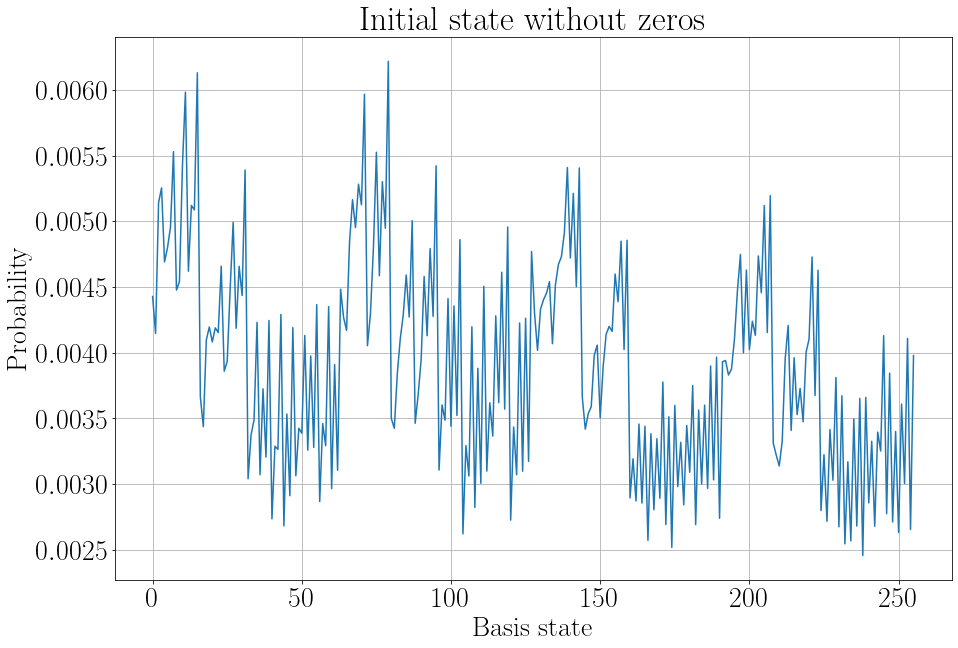

In [14]:
alpha = 1
M = alpha*N

p = 0.05*np.random.randn(2*(N+M+M*N))

fig, ax = plt.subplots()
fig.set_size_inches(15, 10)
state = jnp.exp(logpsi(p, hi.all_states()))
state /= jnp.linalg.norm(state)
prob = jnp.absolute(jnp.square(state))
ax.plot(prob)
ax.set_title("Initial state without zeros")
ax.set_xlabel("Basis state")
ax.set_ylabel("Probability")
ax.grid()

In [15]:
Ns = 1008
x = nksampling(Ns = Ns, p = p)
x_prime, mels = H_ising.get_conn_padded(x)


### Energy

In [16]:
energy_fs = ((state.conj().T @ H @ state)).real
print("The energy from full summation is :", energy_fs)

mean, var = estimate_E(p, x, x_prime, mels)
print(f"The energy from sampling on {Ns} samples is {mean.real} +/- {jnp.sqrt(var.real/Ns)}")

The energy from full summation is : -3.9494932617161473
The energy from sampling on 1008 samples is -4.000380118303516 +/- 0.09383845113221191


In [17]:
p_prime =  0.01*np.random.randn(2*(N+M+M*N))

print("The logL2 from full summation is: ", logL2(p, p_prime, dt, H))

mean_loss, var_loss, _, _ = estimate_logL2(p, p_prime, x, x_prime, mels, dt, eps = 0, error = "yes")
print(f"The logL2 from sampling on {Ns} samples is {mean_loss} +/- {jnp.sqrt(var_loss/Ns)}")

The logL2 from full summation is:  0.13547908040580434
The logL2 from sampling on 1008 samples is 0.14051670338490777 +/- 0.0042136360080583645


In [18]:
print("The L2 from full summation is: ", L2(p, p_prime, dt, H))

mean_loss, var_loss, _, _ = estimate_L2(p, p_prime, x, x_prime, mels, dt, eps = 0, error = "yes")
print(f"The L2 from sampling on {Ns} samples is {mean_loss} +/- {jnp.sqrt(var_loss/Ns)}")

The L2 from full summation is:  0.16124986541772363
The L2 from sampling on 1008 samples is 0.1698738492226446 +/- 0.0056106691593775255


In [19]:
print("The L2_psi from full summation is: ", L2_psi(p, p_prime, dt, H))

mean_loss, var_loss, _, _= estimate_L2_psi(p, p_prime, x, x_prime, mels, dt, eps = 0, error = "yes")
print(f"The L2_psi from sampling on {Ns} samples is {mean_loss} +/- {jnp.sqrt(var_loss/Ns)}")

The L2_psi from full summation is:  0.12511765970739847
The L2_psi from sampling on 1008 samples is 0.1281497345659396 +/- 0.003996275761682181


In [20]:
def infidelity_(wf1, wf2):      
  return 1-(jnp.abs(wf1.conj().T @ wf2)**2)/((jnp.linalg.norm(wf1)**2)*(jnp.linalg.norm(wf2)**2))

### Losses gradients

In [21]:
grad_logL2 = grad(logL2, argnums=1)

print("The gradient of logL2 from full summation is: ", grad_logL2(p, p_prime, dt, H)[:10])

_, _, mean_grad, var_grad = estimate_logL2(p, p_prime, x, x_prime, mels, dt, eps = 0, error = "yes")
print(f"The logL2 from sampling on {Ns} samples is: ")

for i in range(10):
    print(f"{mean_grad[i]} +/- {jnp.sqrt(var_grad[i]/Ns)}")

The gradient of logL2 from full summation is:  [-0.11547948 -0.06215751 -0.02039907 -0.2090448  -0.24148786  0.02010431
 -0.25047759 -0.10569248 -0.01113821 -0.01226056]
The logL2 from sampling on 1008 samples is: 
(-0.1173695527135043+0j) +/- 0.006571144575152709
(-0.0723905211878228+0j) +/- 0.0061489889175141916
(-0.02189779142129173+0j) +/- 0.0017359854467013766
(-0.22052753890476157+0j) +/- 0.003303187971862274
(-0.27136768421668434+0j) +/- 0.009616087431834713
(0.019969476220704385+0j) +/- 0.006571144575152709
(-0.2503128345414418+0j) +/- 0.0012979255608607232
(-0.10547636965693+0j) +/- 0.0006446543749198518
(-0.011840123864389462+0j) +/- 0.0037048462795415695
(-0.012398247743053486+0j) +/- 0.00241439117623616


In [22]:
grad_L2 = grad(L2, argnums=1)

print("The gradient of L2 from full summation is: ", grad_L2(p, p_prime, dt, H)[:10])

_, _, mean_grad, var_grad = estimate_L2(p, p_prime, x, x_prime, mels, dt, eps = 0, error = "yes")
print(f"The L2 from sampling on {Ns} samples is: ")

for i in range(10):
    print(f"{mean_grad[i]} +/- {jnp.sqrt(var_grad[i]/Ns)}")

The gradient of L2 from full summation is:  [-0.11382579 -0.11307548 -0.03264915 -0.19627855 -0.2475264   0.06994546
 -0.21292766 -0.08480617 -0.01184811 -0.0135453 ]
The L2 from sampling on 1008 samples is: 
(-0.11908779902235711+0j) +/- 0.007865313941595025
(-0.1240007949936996+0j) +/- 0.008202534943238112
(-0.0352552256221814+0j) +/- 0.0019512595912841335
(-0.2225219245560453+0j) +/- 0.0030007228197731464
(-0.2762546744355913+0j) +/- 0.01094612810927469
(0.07247169937854321+0j) +/- 0.007865313941595025
(-0.21330652088945778+0j) +/- 0.0012380050547092644
(-0.08253576064472389+0j) +/- 0.0006244189359625203
(-0.01230052930841054+0j) +/- 0.0034959460546448787
(-0.014005100707114027+0j) +/- 0.002633996714318415


In [23]:
grad_L2_psi = grad(L2_psi, argnums=1)

print("The gradient of logL2 from full summation is: ", grad_L2_psi(p, p_prime, dt, H)[:10])

_, _, mean_grad, var_grad = estimate_L2_psi(p, p_prime, x, x_prime, mels, dt, eps = 0, error = "yes")
print(f"The L2_psi from sampling on {Ns} samples is: ")

for i in range(10):
    print(f"{mean_grad[i]} +/- {jnp.sqrt(var_grad[i]/Ns)}")

The gradient of logL2 from full summation is:  [-0.10580003 -0.08654408 -0.03107196 -0.1741592  -0.20520312  0.03254803
 -0.16417352 -0.07347112 -0.01091473 -0.01239407]
The L2_psi from sampling on 1008 samples is: 
(-0.09761038174338156+0j) +/- 0.004981814018821304
(-0.0861080861483077+0j) +/- 0.0033298312613363125
(-0.03122043039323701+0j) +/- 0.0014494557358023085
(-0.18239883834866696+0j) +/- 0.004673698093502907
(-0.21587115300125997+0j) +/- 0.007311087896182448
(0.0321459171953121+0j) +/- 0.004981814018821304
(-0.1425717067600868+0j) +/- 0.001478399448008432
(-0.07082377309616288+0j) +/- 0.000688834222806586
(-0.011288736414751643+0j) +/- 0.005181357858570576
(-0.012397683866738556+0j) +/- 0.002292066380359532


# Optimization: target state without zeros

We start with a state without zeros. 

The minimum value of the born distribution is:  0.4041891890763645


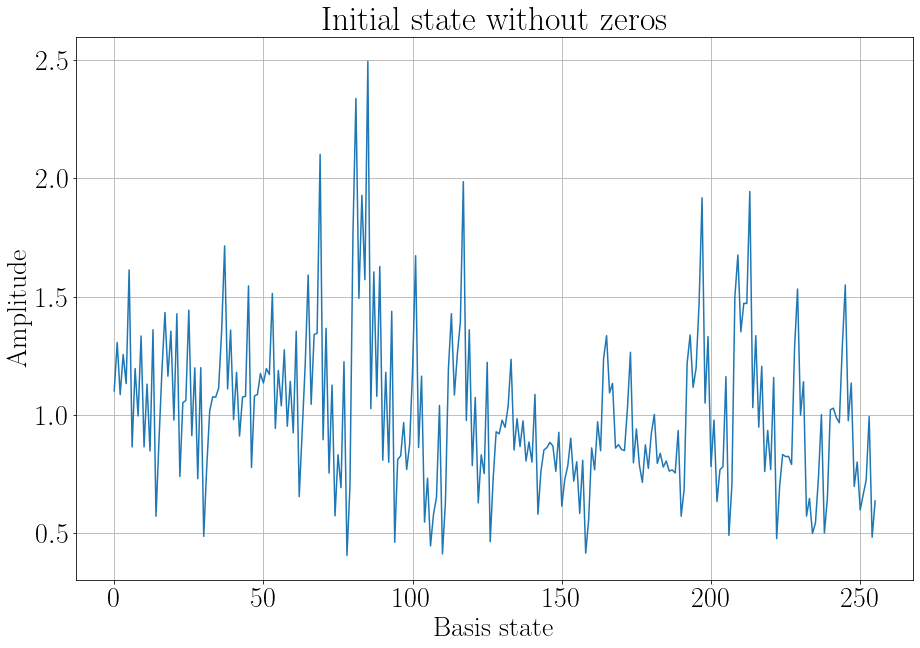

In [15]:
alpha = 1
p = 0.05*np.random.randn(2*(N+M+M*N))

fig, ax = plt.subplots()
fig.set_size_inches(15, 10)

state = jnp.exp(logpsi(p,hi.all_states()))
#state /= jnp.linalg.norm(state)
prob = jnp.square(jnp.absolute(state))

ax.plot(prob)
ax.set_title("Initial state without zeros")
ax.set_xlabel("Basis state")
ax.set_ylabel("Amplitude")
ax.grid()

print("The minimum value of the born distribution is: ", np.min(prob))

## Generate a big pool of samples

In [17]:
n_iter_max = 2000
Ns = 1008
pool_of_samples = generate_pool_of_samples(p = p, n_samples_per_iter=Ns, n_iter_max=n_iter_max, rescaling_factor = 10)

In [18]:
dict = {"Type of loss": [r"$\mathcal{L}_{linear}$", r"$\mathcal{L}_{log}$", 
        r"$\mathcal{L}$"], "loss_values_Adam_fs": [],  
        "infidelity_values_Adam_fs": [],  "final_iter_fs":[],
        "loss_values_Adam_sampling": [],  "infidelity_values_Adam_sampling": [],
        "final_iter_sampling": []}

## $\mathcal{L}_{lin}$

In [19]:
lr = 0.01
tol = 1e-5

final_iter_fs, p_prime_fs, loss_values_Adam_fs, infidelity_values_Adam_fs = optimize_Adam(p, p, L2, dt, H, lr = lr, tol = tol, n_iter_max = n_iter_max, beta1=0.9, beta2=0.999, epsilon=1e-8, method = "full_summation")
dict["loss_values_Adam_fs"].append(loss_values_Adam_fs)
dict["infidelity_values_Adam_fs"].append(infidelity_values_Adam_fs)
dict["final_iter_fs"].append(final_iter_fs)

final_iter_sampling, p_prime_sampling, loss_values_Adam_sampling, infidelity_values_Adam_sampling = optimize_Adam(p, p, estimate_L2, dt, H, lr = lr, tol = tol, n_iter_max = n_iter_max, beta1=0.9, beta2=0.999, epsilon=1e-8, Ns = Ns, pool_of_samples = pool_of_samples, method = "sampling")
dict["loss_values_Adam_sampling"].append(loss_values_Adam_sampling)
dict["infidelity_values_Adam_sampling"].append(infidelity_values_Adam_sampling)
dict["final_iter_sampling"].append(final_iter_sampling)



Iteration number:  0
Iteration number:  50
Number of iteration to converge:  80
Iteration number:  0
Iteration number:  50
Number of iteration to converge:  79


In [21]:
loss_values_Adam_fs = dict["loss_values_Adam_fs"][0]
infidelity_values_Adam_fs = dict["infidelity_values_Adam_fs"][0]
final_iter_fs = dict["final_iter_fs"][0]

loss_values_Adam_sampling = dict["loss_values_Adam_sampling"][0]
infidelity_values_Adam_sampling = dict["infidelity_values_Adam_sampling"][0]
final_iter_sampling = dict["final_iter_sampling"][0]

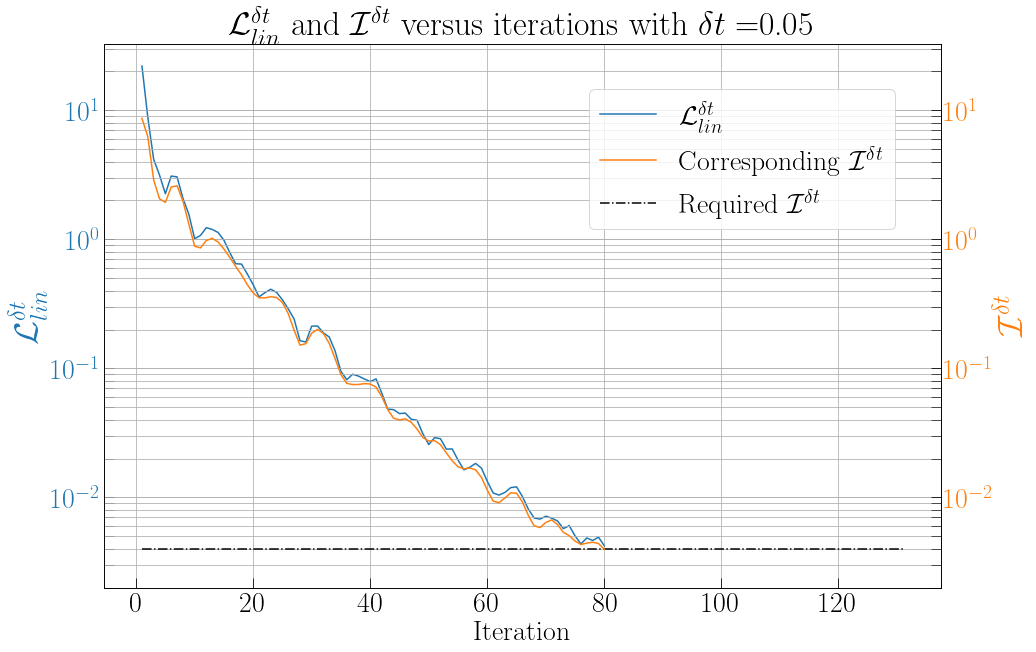

In [24]:
fig, ax1 = plt.subplots()
fig.set_size_inches(15, 10)
color = 'tab:blue'
ax1.set_xlabel('Iteration')
ax1.set_ylabel(r'$\mathcal{L}_{lin}^{\delta t}$', color = color, fontsize = 35)
ax1.plot(np.arange(len(loss_values_Adam_sampling))+1, jnp.array(loss_values_Adam_sampling)/dt**2, color = color, label = '$\mathcal{L}_{lin}^{\delta t}$')
#ax1.plot(np.arange(len(loss_values_Adam_fs))+1, jnp.array(loss_values_Adam_fs)/dt**2, color = color, linestyle = 'dashed', label = '$\mathcal{L}_{lin}^{\delta t}$ exact')

ax1.tick_params(axis ='y', labelcolor = color, which = "both", direction = 'in', length = 10)
ax1.tick_params(axis ='x', which = "both", direction = 'in', length = 10)

ax1.set_yscale('log')
#ax1.set_xscale('log')
ax1.grid(which = "major")

ax2 = ax1.twinx()
color = 'tab:orange'
ax2.set_ylabel(r'$\mathcal{I}^{\delta t}$', color = color, fontsize = 35)
ax2.plot(np.arange(len(infidelity_values_Adam_sampling))+1, jnp.array(infidelity_values_Adam_sampling)/dt**2, color = color, label = r'Corresponding $\mathcal{I}^{\delta t}$')
#ax2.plot(np.arange(len(infidelity_values_Adam_fs))+1, jnp.array(infidelity_values_Adam_fs)/dt**2, color = color, linestyle = 'dashed', label = r'Relative $\mathcal{I}^{\delta t}$ exact')
ax2.hlines(tol/dt**2, 1, max(len(infidelity_values_Adam_fs), len(infidelity_values_Adam_sampling))+50, color = "black", linestyle = "dashdot", label = r"Required $\mathcal{I}^{\delta t}$")

ax2.tick_params(axis ='y', labelcolor = color, which = "both", direction = 'in', length = 10)
ax2.set_yscale('log')
#ax2.set_xscale('log')

max1 = jnp.max(jnp.array(infidelity_values_Adam_fs)/dt**2)
max2 = jnp.max(jnp.array(infidelity_values_Adam_sampling)/dt**2)
max3 = jnp.max(jnp.array(loss_values_Adam_fs)/dt**2)
max4 = jnp.max(jnp.array(loss_values_Adam_sampling)/dt**2)

upper_bound = max(max1, max2, max3, max4)

ax1.set_ylim([0.5*tol/dt**2, upper_bound+10])
ax2.set_ylim([0.5*tol/dt**2, upper_bound+10])
ax2.grid(which = "both")

fig.legend(loc='right', bbox_to_anchor=(0.87, 0.72))


#ax1.text(440, 1.2e-1, f' \n Iterations to converge: {final_iter_sampling} \n', bbox = {"fc" : "white"}, backgroundcolor = "white")
#ax2.text(440, 1.2e-1, f'\n Iterations to converge: {final_iter_sampling} \n', bbox = {"fc" : "white"}, backgroundcolor = "white")

ax1.set_title(r"$\mathcal{L}_{lin}^{\delta t}$ and $\mathcal{I}^{\delta t}$ versus iterations with $\delta t = $"+str(dt))
fig.savefig("dt_optimization_no_zero_L_lin.jpeg")

In [25]:
print("The initial infidelity is: ", infidelity_values_Adam_sampling[0])
print("The final infidelity is: ", infidelity_values_Adam_sampling[-1])
print("Number of iteration to converge: ", final_iter_sampling)

The initial infidelity is:  0.02161858671780914
The final infidelity is:  9.915638957247452e-06
Number of iteration to converge:  79


## $\mathcal{L}_{log}$

In [26]:
lr = 0.01
tol =  1e-5

final_iter_fs, p_prime_fs, loss_values_Adam_fs, infidelity_values_Adam_fs = optimize_Adam(p, p, logL2, dt, H, lr = lr, tol = tol, n_iter_max = n_iter_max, beta1=0.9, beta2=0.999, epsilon=1e-8, method = "full_summation")
dict["loss_values_Adam_fs"].append(loss_values_Adam_fs)
dict["infidelity_values_Adam_fs"].append(infidelity_values_Adam_fs)
dict["final_iter_fs"].append(final_iter_fs)

final_iter_sampling, p_prime_sampling, loss_values_Adam_sampling, infidelity_values_Adam_sampling = optimize_Adam(p, p, estimate_logL2, dt, H, lr = lr, tol = tol, n_iter_max = n_iter_max, beta1=0.9, beta2=0.999, epsilon=1e-8, Ns = Ns, pool_of_samples = pool_of_samples, method = "sampling")
dict["loss_values_Adam_sampling"].append(loss_values_Adam_sampling)
dict["infidelity_values_Adam_sampling"].append(infidelity_values_Adam_sampling)
dict["final_iter_sampling"].append(final_iter_sampling)



Iteration number:  0
Iteration number:  50
Number of iteration to converge:  77
Iteration number:  0
Iteration number:  50
Number of iteration to converge:  77


In [27]:
loss_values_Adam_fs = dict["loss_values_Adam_fs"][1]
infidelity_values_Adam_fs = dict["infidelity_values_Adam_fs"][1]
final_iter_fs = dict["final_iter_fs"][1]

loss_values_Adam_sampling = dict["loss_values_Adam_sampling"][1]
infidelity_values_Adam_sampling = dict["infidelity_values_Adam_sampling"][1]
final_iter_sampling = dict["final_iter_sampling"][1]

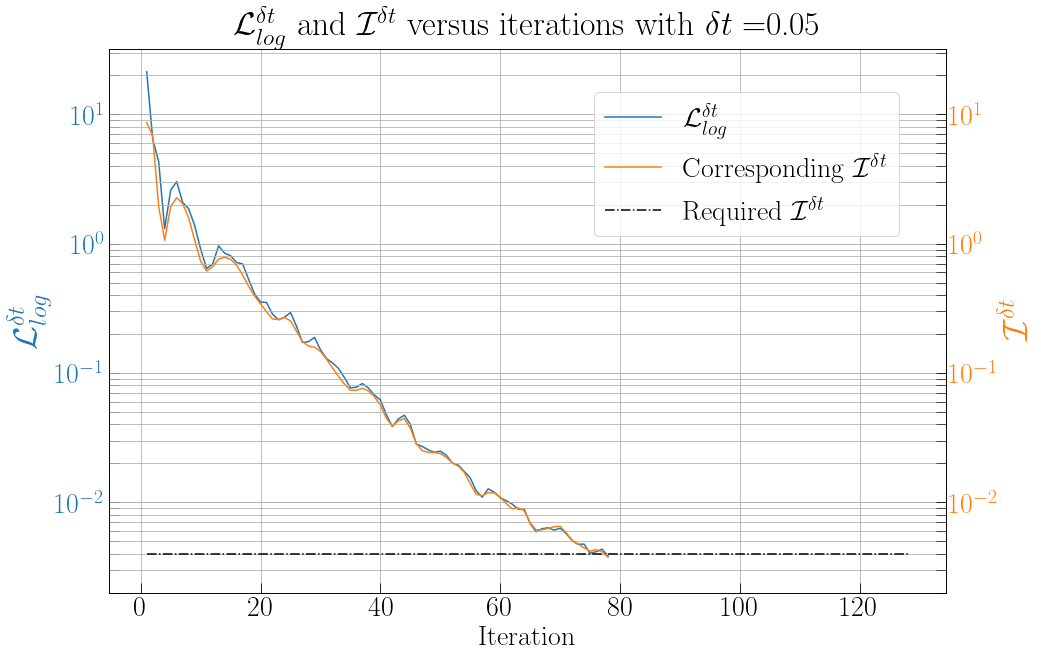

In [28]:
fig, ax1 = plt.subplots()
fig.set_size_inches(15, 10)
color = 'tab:blue'
ax1.set_xlabel('Iteration')
ax1.set_ylabel(r'$\mathcal{L}_{log}^{\delta t}$', color = color, fontsize = 35)
ax1.plot(np.arange(len(loss_values_Adam_sampling))+1, jnp.array(loss_values_Adam_sampling)/dt**2, color = color, label = '$\mathcal{L}_{log}^{\delta t}$')
#ax1.plot(np.arange(len(loss_values_Adam_fs))+1, jnp.array(loss_values_Adam_fs)/dt**2, color = color, linestyle = 'dashed', label = '$\mathcal{L}_{log}^{\delta t}$ exact')

ax1.tick_params(axis ='y', labelcolor = color, which = "both", direction = 'in', length = 10)
ax1.tick_params(axis ='x', which = "both", direction = 'in', length = 10)

ax1.set_yscale('log')
#ax1.set_xscale('log')
ax1.grid(which = "major")

ax2 = ax1.twinx()
color = 'tab:orange'
ax2.set_ylabel(r'$\mathcal{I}^{\delta t}$', color = color, fontsize = 35)
ax2.plot(np.arange(len(infidelity_values_Adam_sampling))+1, jnp.array(infidelity_values_Adam_sampling)/dt**2, color = color, label = r'Corresponding $\mathcal{I}^{\delta t}$')
#ax2.plot(np.arange(len(infidelity_values_Adam_fs))+1, jnp.array(infidelity_values_Adam_fs)/dt**2, color = color, linestyle = 'dashed', label = r'Relative $\mathcal{I}^{\delta t}$ exact')
ax2.hlines(tol/dt**2, 1, max(len(infidelity_values_Adam_fs), len(infidelity_values_Adam_sampling))+50, color = "black", linestyle = "dashdot", label = r"Required $\mathcal{I}^{\delta t}$")


ax2.tick_params(axis ='y', labelcolor = color, which = "both", direction = 'in', length = 10)
ax2.set_yscale('log')
#ax2.set_xscale('log')

max1 = jnp.max(jnp.array(infidelity_values_Adam_fs)/dt**2)
max2 = jnp.max(jnp.array(infidelity_values_Adam_sampling)/dt**2)
max3 = jnp.max(jnp.array(loss_values_Adam_fs)/dt**2)
max4 = jnp.max(jnp.array(loss_values_Adam_sampling)/dt**2)

upper_bound = max(max1, max2, max3, max4)

ax1.set_ylim([0.5*tol/dt**2, upper_bound+10])
ax2.set_ylim([0.5*tol/dt**2, upper_bound+10])
ax2.grid(which = "both")

fig.legend(loc='right', bbox_to_anchor=(0.87, 0.72))


#ax1.text(360, 1.2e-1, f' \n Iterations to converge: {final_iter_sampling} \n', bbox = {"fc" : "white"}, backgroundcolor = "white")
#ax2.text(360, 1.2e-1, f'\n Iterations to converge: {final_iter_sampling} \n', bbox = {"fc" : "white"}, backgroundcolor = "white")

ax1.set_title(r"$\mathcal{L}_{log}^{\delta t}$ and $\mathcal{I}^{\delta t}$ versus iterations with $\delta t = $"+str(dt))
fig.savefig("dt_optimization_no_zero_L_log.jpeg")

In [29]:
print("The initial infidelity is: ", infidelity_values_Adam_sampling[0])
print("The final infidelity is: ", infidelity_values_Adam_sampling[-1])
print("Number of iteration to converge: ", final_iter_sampling)

The initial infidelity is:  0.02161858671780914
The final infidelity is:  9.389815508131782e-06
Number of iteration to converge:  77


## $\mathcal{L}$

In [30]:
lr = 0.01
tol =  1e-5

final_iter_fs, p_prime_fs, loss_values_Adam_fs, infidelity_values_Adam_fs = optimize_Adam(p, p, L2_psi, dt, H, lr = lr, tol = tol, n_iter_max = n_iter_max, beta1=0.9, beta2=0.999, epsilon=1e-8, method = "full_summation")
dict["loss_values_Adam_fs"].append(loss_values_Adam_fs)
dict["infidelity_values_Adam_fs"].append(infidelity_values_Adam_fs)
dict["final_iter_fs"].append(final_iter_fs)

final_iter_sampling, p_prime_sampling, loss_values_Adam_sampling, infidelity_values_Adam_sampling = optimize_Adam(p, p, estimate_L2_psi, dt, H, lr = lr, tol = tol, n_iter_max = n_iter_max, beta1=0.9, beta2=0.999, epsilon=1e-8, Ns = Ns, pool_of_samples = pool_of_samples, method = "sampling")
dict["loss_values_Adam_sampling"].append(loss_values_Adam_sampling)
dict["infidelity_values_Adam_sampling"].append(infidelity_values_Adam_sampling)
dict["final_iter_sampling"].append(final_iter_sampling)



Iteration number:  0
Iteration number:  50
Number of iteration to converge:  76
Iteration number:  0
Iteration number:  50
Number of iteration to converge:  81


In [31]:
loss_values_Adam_fs = dict["loss_values_Adam_fs"][2]
infidelity_values_Adam_fs = dict["infidelity_values_Adam_fs"][2]
final_iter_fs = dict["final_iter_fs"][2]

loss_values_Adam_sampling = dict["loss_values_Adam_sampling"][2]
infidelity_values_Adam_sampling = dict["infidelity_values_Adam_sampling"][2]
final_iter_sampling = dict["final_iter_sampling"][2]

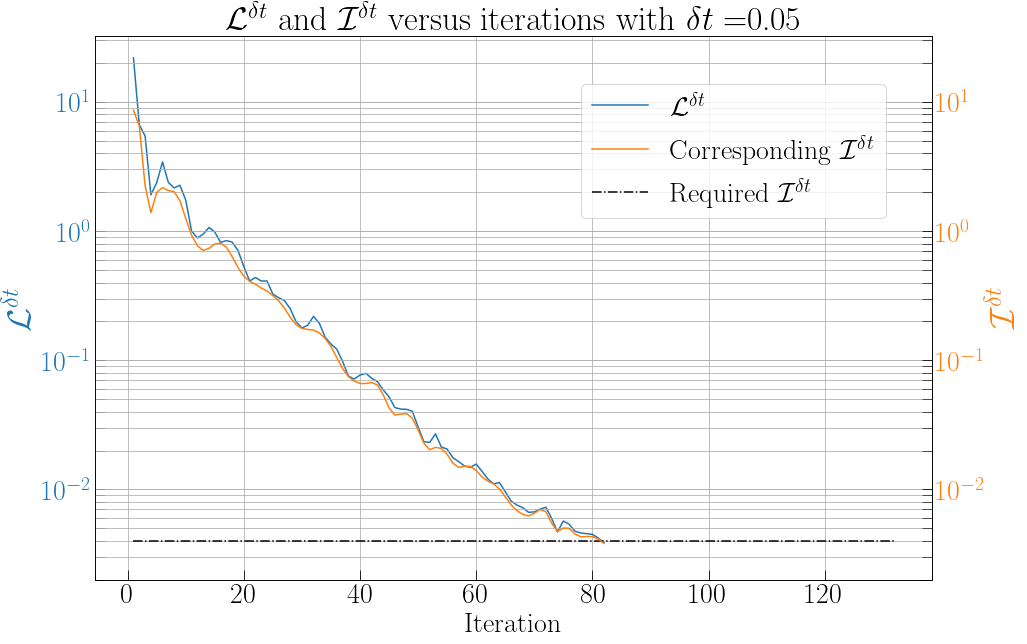

In [33]:
fig, ax1 = plt.subplots()
fig.set_size_inches(15, 10)
color = 'tab:blue'
ax1.set_xlabel('Iteration')
ax1.set_ylabel(r'$\mathcal{L}^{\delta t}$', color = color, fontsize = 35)
ax1.plot(np.arange(len(loss_values_Adam_sampling))+1, jnp.array(loss_values_Adam_sampling)/dt**2, color = color, label = '$\mathcal{L}^{\delta t}$')
#ax1.plot(np.arange(len(loss_values_Adam_fs))+1, jnp.array(loss_values_Adam_fs)/dt**2, color = color, linestyle = 'dashed', label = '$\mathcal{L}^{\delta t}$ exact')

ax1.tick_params(axis ='y', labelcolor = color, which = "both", direction = 'in', length = 10)
ax1.tick_params(axis ='x', which = "both", direction = 'in', length = 10)

ax1.set_yscale('log')
#ax1.set_xscale('log')
ax1.grid(which = "major")

ax2 = ax1.twinx()
color = 'tab:orange'
ax2.set_ylabel(r'$\mathcal{I}^{\delta t}$', color = color, fontsize = 35)
ax2.plot(np.arange(len(infidelity_values_Adam_sampling))+1, jnp.array(infidelity_values_Adam_sampling)/dt**2, color = color, label = r'Corresponding $\mathcal{I}^{\delta t}$')
#ax2.plot(np.arange(len(infidelity_values_Adam_fs))+1, jnp.array(infidelity_values_Adam_fs)/dt**2, color = color, linestyle = 'dashed', label = r'Relative $\mathcal{I}^{\delta t}$ exact')
ax2.hlines(tol/dt**2, 1, max(len(infidelity_values_Adam_fs), len(infidelity_values_Adam_sampling))+50, color = "black", linestyle = "dashdot", label = r"Required $\mathcal{I}^{\delta t}$")


ax2.tick_params(axis ='y', labelcolor = color, which = "both", direction = 'in', length = 10)
ax2.set_yscale('log')
#ax2.set_xscale('log')

max1 = jnp.max(jnp.array(infidelity_values_Adam_fs)/dt**2)
max2 = jnp.max(jnp.array(infidelity_values_Adam_sampling)/dt**2)
max3 = jnp.max(jnp.array(loss_values_Adam_fs)/dt**2)
max4 = jnp.max(jnp.array(loss_values_Adam_sampling)/dt**2)

upper_bound = max(max1, max2, max3, max4)

ax1.set_ylim([0.5*tol/dt**2, upper_bound+10])
ax2.set_ylim([0.5*tol/dt**2, upper_bound+10])
ax2.grid(which = "both")

fig.legend(loc='right', bbox_to_anchor=(0.87, 0.72))


#ax1.text(420, 1.2e-1, f' \n Iterations to converge: {final_iter_sampling} \n', bbox = {"fc" : "white"}, backgroundcolor = "white")
#ax2.text(420, 1.2e-1, f'\n Iterations to converge: {final_iter_sampling} \n', bbox = {"fc" : "white"}, backgroundcolor = "white")

ax1.set_title(r"$\mathcal{L}^{\delta t}$ and $\mathcal{I}^{\delta t}$ versus iterations with $\delta t = $"+str(dt))
fig.savefig("dt_optimization_no_zero_L.jpeg")

In [34]:
print("The initial infidelity is: ", infidelity_values_Adam_sampling[0])
print("The final infidelity is: ", infidelity_values_Adam_sampling[-1])
print("Number of iteration to converge: ", final_iter_sampling)

The initial infidelity is:  0.02161858671780914
The final infidelity is:  9.559357256883061e-06
Number of iteration to converge:  81


Iif we use a higher learning rate with convergence but more iterations and with spikes at the end of the optimization. 

# Testing Adam vs SGD

In [47]:
lr = 0.01
tol = 1e-5
n_iter_max = 50000

final_iter_SGD_sampling, p_prime_SGD_sampling, loss_values_SGD_sampling, infidelity_values_SGD_sampling = optimize_SGD(p, p, estimate_L2_psi, dt, H, lr = lr, tol = tol, n_iter_max = n_iter_max, beta1=0.9, beta2=0.999, epsilon=1e-8, Ns = Ns, pool_of_samples = pool_of_samples, method = "sampling")
final_iter_Adam_sampling, p_prime_Adam_sampling, loss_values_Adam_sampling, infidelity_values_Adam_sampling = optimize_Adam(p, p, estimate_L2_psi, dt, H, lr = lr, tol = tol, n_iter_max = n_iter_max, beta1=0.9, beta2=0.999, epsilon=1e-8, Ns = Ns, pool_of_samples = pool_of_samples, method = "sampling")



Iteration number:  0
Iteration number:  50
Iteration number:  100
Iteration number:  150
Iteration number:  200
Iteration number:  250
Iteration number:  300
Iteration number:  350
Iteration number:  400
Iteration number:  450
Iteration number:  500
Iteration number:  550
Iteration number:  600
Iteration number:  650
Iteration number:  700
Iteration number:  750
Iteration number:  800
Iteration number:  850
Iteration number:  900
Iteration number:  950
Iteration number:  1000
Iteration number:  1050
Iteration number:  1100
Iteration number:  1150
Iteration number:  1200
Iteration number:  1250
Iteration number:  1300
Iteration number:  1350
Iteration number:  1400
Iteration number:  1450
Iteration number:  1500
Iteration number:  1550
Iteration number:  1600
Iteration number:  1650
Iteration number:  1700
Iteration number:  1750
Iteration number:  1800
Iteration number:  1850
Iteration number:  1900
Iteration number:  1950
Iteration number:  2000
Iteration number:  2050
Iteration numbe

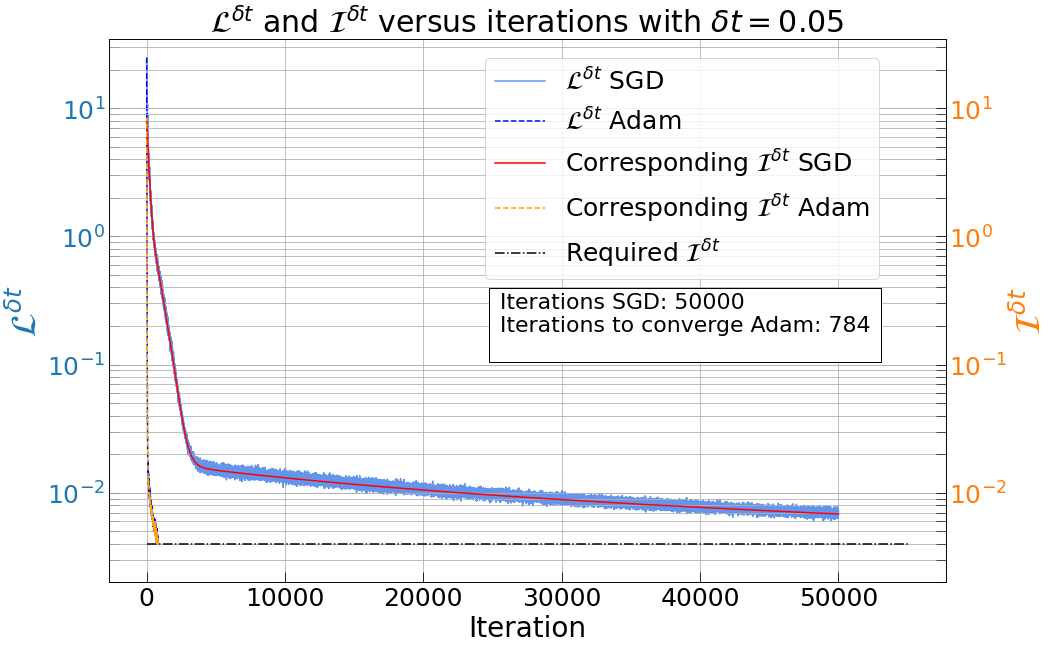

In [75]:
fig, ax1 = plt.subplots()
fig.set_size_inches(15, 10)
color = 'tab:blue'
ax1.set_xlabel('Iteration', fontsize = 28)
ax1.set_ylabel(r'$\mathcal{L}^{\delta t}$', color = color, fontsize = 35)
ax1.plot(np.arange(len(loss_values_SGD_sampling))+1, jnp.array(loss_values_SGD_sampling)/dt**2, color = "cornflowerblue", label = '$\mathcal{L}^{\delta t}$ SGD')
ax1.plot(np.arange(len(loss_values_Adam_sampling))+1, jnp.array(loss_values_Adam_sampling)/dt**2, color = "blue", linestyle = 'dashed', label = '$\mathcal{L}^{\delta t}$ Adam')

ax1.tick_params(axis ='y', labelcolor = color, which = "both", direction = 'in', length = 10)
ax1.tick_params(axis ='x', which = "both", direction = 'in', length = 10)

ax1.set_yscale('log')
#ax1.set_xscale('log')
ax1.grid(which = "major")

ax2 = ax1.twinx()
color = 'tab:orange'
ax2.set_ylabel(r'$\mathcal{I}^{\delta t}$', color = color, fontsize = 35)
ax2.plot(np.arange(len(infidelity_values_SGD_sampling))+1, jnp.array(infidelity_values_SGD_sampling)/dt**2, color = "red", label = r'Corresponding $\mathcal{I}^{\delta t}$ SGD')
ax2.plot(np.arange(len(infidelity_values_Adam_sampling))+1, jnp.array(infidelity_values_Adam_sampling)/dt**2, color = "orange", linestyle = 'dashed', label = r'Corresponding $\mathcal{I}^{\delta t}$ Adam')
ax2.hlines(tol/dt**2, 1, 1.1*n_iter_max, color = "black", linestyle = "dashdot", label = r"Required $\mathcal{I}^{\delta t}$")


ax2.tick_params(axis ='y', labelcolor = color, which = "both", direction = 'in', length = 10)
ax2.set_yscale('log')
#ax2.set_xscale('log')

max1 = jnp.max(jnp.array(infidelity_values_SGD_sampling)/dt**2)
max2 = jnp.max(jnp.array(infidelity_values_Adam_sampling)/dt**2)
max3 = jnp.max(jnp.array(loss_values_SGD_sampling)/dt**2)
max4 = jnp.max(jnp.array(loss_values_Adam_sampling)/dt**2)

upper_bound = max(max1, max2, max3, max4)

ax1.set_ylim([0.5*tol/dt**2, upper_bound+10])
ax2.set_ylim([0.5*tol/dt**2, upper_bound+10])
ax2.grid(which = "both")

fig.legend(loc='right', bbox_to_anchor=(0.85, 0.7))


ax1.text(2.5e4, 1.2e-1, f' Iterations SGD: {len(loss_values_SGD_sampling)-1} \n Iterations to converge Adam: {len(loss_values_Adam_sampling)-1} \n ',  fontsize = 22, bbox = {"fc" : "white"}, backgroundcolor = "white")
ax2.text(2.5e4, 1.2e-1, f' Iterations SGD: {len(loss_values_SGD_sampling)-1} \n Iterations to converge Adam: {len(loss_values_Adam_sampling)-1} \n ',  fontsize = 22, bbox = {"fc" : "white"}, backgroundcolor = "white")

ax1.set_title(r"$\mathcal{L}^{\delta t}$ and $\mathcal{I}^{\delta t}$ versus iterations with $\delta t = $"+str(dt))
fig.savefig("dt_optimization_Adam_vs_SGD_no_hard_zeros_L.jpeg")

# Optimization: target state with zeros

We start with a state with zeros. 

The minimum value of the born distribution is:  2.0180759425160335e-14


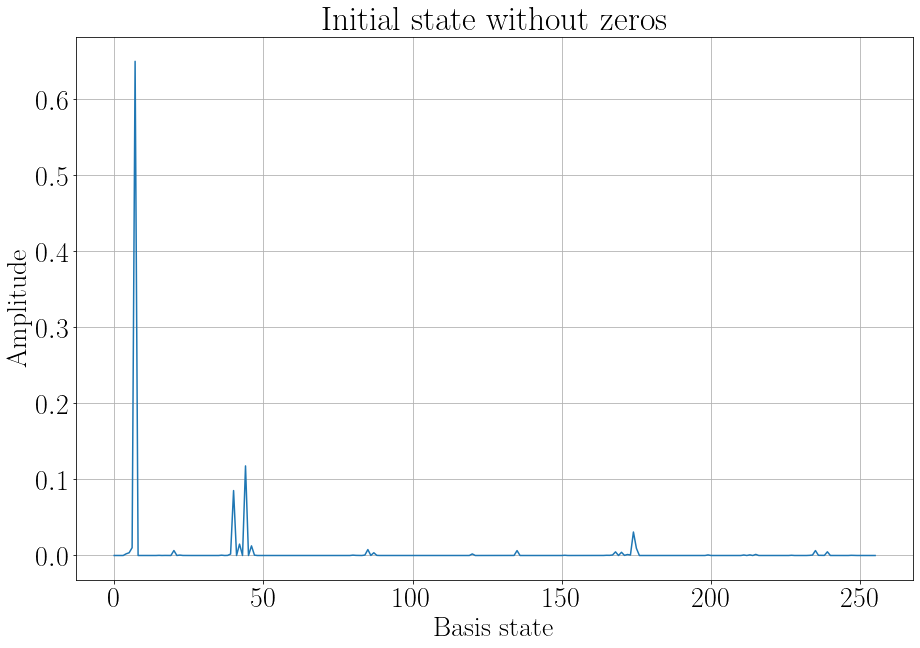

In [28]:
alpha = 1
p = 0.5*np.random.randn(2*(N+M+M*N))

fig, ax = plt.subplots()
fig.set_size_inches(15, 10)

state = jnp.exp(logpsi(p,hi.all_states()))
state /= jnp.linalg.norm(state)
prob = jnp.square(jnp.absolute(state))

ax.plot(prob)
ax.set_title("Initial state without zeros")
ax.set_xlabel("Basis state")
ax.set_ylabel("Amplitude")
ax.grid()

print("The minimum value of the born distribution is: ", np.min(prob))

In [16]:
#np.savetxt("state_with_zeros.txt", p)

## Generate a big pool of samples

In [29]:
n_iter_max = 20000
Ns = 1008
pool_of_samples = generate_pool_of_samples(p = p, n_samples_per_iter=Ns, n_iter_max=n_iter_max, rescaling_factor = 10)
eps = dt*jnp.max(jnp.absolute(jnp.exp(logpsi(p, pool_of_samples))))
pool_of_samples_smearing = generate_pool_of_samples(p = p, n_samples_per_iter=Ns, n_iter_max=n_iter_max, rescaling_factor = 100, eps = eps, method = "diy")


In [30]:
pool_of_samples_ = generate_pool_of_samples(p = p, n_samples_per_iter=Ns, n_iter_max=n_iter_max, rescaling_factor = 10)
pool_of_samples_extended = np.concatenate((pool_of_samples_, pool_of_samples))

print(pool_of_samples.shape)
print(pool_of_samples_extended.shape)

(2016000, 8)
(4032000, 8)


In [16]:
def binatodeci(binary):
    return sum(val*(2**idx) for idx, val in enumerate(reversed(binary)))

def statetoidx(state): 
    idxs = (state+1)/2
    idxs = [int(binatodeci(idx)) for idx in idxs]
    return idxs

In [17]:
idxs = statetoidx(pool_of_samples)
idxs_smearing = statetoidx(pool_of_samples_smearing)

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches(8, 5)
ax.set_yscale('log')
ax.hist(idxs, bins = 2**N, density=True, range=[0, 2**N])
ax.set_title(f"Distribution with no smearing (Ns_tot = {len(idxs)})")

fig, ax = plt.subplots()
fig.set_size_inches(8, 5)
ax.set_yscale('log')
plt.hist(idxs_smearing, bins = 2**N, density=True)
plt.title(f"Distribution with smearing (Ns_tot = {len(idxs_smearing)})")


In [14]:
dict_zeros = {"Type of loss": [r"$\mathcal{L}_{linear}$", r"$\mathcal{L}_{log}$", 
        r"$\mathcal{L}$"], "loss_values_Adam": [],  
        "infidelity_values_Adam": [],  "final_iter":[],
        "loss_values_Adam_smearing": [],  "infidelity_values_Adam_smearing": [],
        "final_iter_smearing": [], "loss_values_Adam_noise": [],  "infidelity_values_Adam_noise": [],
        "final_iter_noise": []}

# Read data

In [15]:
dict_zeros["loss_values_Adam"].append(np.loadtxt("loss_values_lin.txt"))
dict_zeros["infidelity_values_Adam"].append(np.loadtxt("infidelity_values_lin.txt"))

dict_zeros["loss_values_Adam_smearing"].append(np.loadtxt("loss_values_smearing_lin.txt"))
dict_zeros["infidelity_values_Adam_smearing"].append(np.loadtxt("infidelity_values_smearing_lin.txt"))

#dict_zeros["loss_values_Adam"].append(np.loadtxt("loss_values_log.txt"))
#dict_zeros["infidelity_values_Adam"].append(np.loadtxt("infidelity_values_log.txt"))

#dict_zeros["loss_values_Adam_smearing"].append(np.loadtxt("loss_values_smearing_log.txt"))
#dict_zeros["infidelity_values_Adam_smearing"].append(np.loadtxt("infidelity_values_smearing_log.txt"))

dict_zeros["loss_values_Adam"].append(np.loadtxt("loss_values.txt"))
dict_zeros["infidelity_values_Adam"].append(np.loadtxt("infidelity_values.txt"))

dict_zeros["loss_values_Adam_smearing"].append(np.loadtxt("loss_values_smearing.txt"))
dict_zeros["infidelity_values_Adam_smearing"].append(np.loadtxt("infidelity_values_smearing.txt"))

## $\mathcal{L}_{lin}$

In [17]:
lr = 0.001
tol = 1e-5

In [33]:
final_iter, p_prime, loss_values_Adam, infidelity_values_Adam = optimize_Adam(p, p, estimate_L2, dt, H, lr = lr, tol = tol, n_iter_max = n_iter_max, beta1=0.9, beta2=0.999, epsilon=1e-8, Ns = Ns, pool_of_samples = pool_of_samples, method = "sampling")
dict_zeros["loss_values_Adam"].append(loss_values_Adam)
dict_zeros["infidelity_values_Adam"].append(infidelity_values_Adam)
dict_zeros["final_iter"].append(final_iter)

final_iter_smearing, p_prime_smearing, loss_values_Adam_smearing, infidelity_values_Adam_smearing = optimize_Adam(p, p, estimate_L2, dt, H, lr = lr, tol = tol, n_iter_max = n_iter_max, beta1=0.9, beta2=0.999, epsilon=1e-8, Ns = Ns, pool_of_samples = pool_of_samples_smearing, method = "sampling", eps = eps)
dict_zeros["loss_values_Adam_smearing"].append(loss_values_Adam_smearing)
dict_zeros["infidelity_values_Adam_smearing"].append(infidelity_values_Adam_smearing)
dict_zeros["final_iter_smearing"].append(final_iter_smearing)



Iteration number:  0
Iteration number:  50
Iteration number:  100
Iteration number:  150
Iteration number:  200
Iteration number:  250
Iteration number:  300
Iteration number:  350
Iteration number:  400
Iteration number:  450
Iteration number:  500
Iteration number:  550
Iteration number:  600
Iteration number:  650
Iteration number:  700
Iteration number:  750
Iteration number:  800
Iteration number:  850
Iteration number:  900
Iteration number:  950
Iteration number:  1000
Iteration number:  1050
Iteration number:  1100
Iteration number:  1150
Iteration number:  1200
Iteration number:  1250
Iteration number:  1300
Iteration number:  1350
Iteration number:  1400
Iteration number:  1450
Iteration number:  1500
Iteration number:  1550
Iteration number:  1600
Iteration number:  1650
Iteration number:  1700
Iteration number:  1750
Iteration number:  1800
Iteration number:  1850
Iteration number:  1900
Iteration number:  1950
Iteration number:  2000
Iteration number:  2050
Iteration numbe

In [97]:
loss_values_Adam = dict_zeros["loss_values_Adam"][0]
infidelity_values_Adam = dict_zeros["infidelity_values_Adam"][0]
#final_iter = dict_zeros["final_iter"][0]

loss_values_Adam_smearing = dict_zeros["loss_values_Adam_smearing"][0]
infidelity_values_Adam_smearing = dict_zeros["infidelity_values_Adam_smearing"][0]
#final_iter_smearing = dict_zeros["final_iter_smearing"][0]

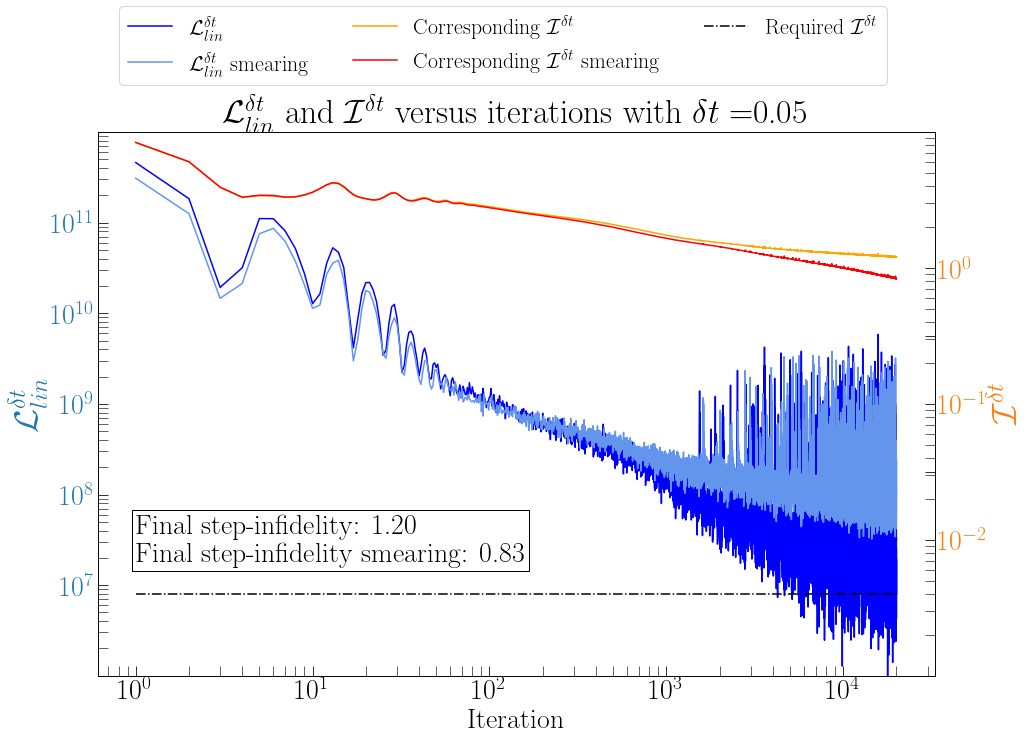

In [105]:
fig, ax1 = plt.subplots()
fig.set_size_inches(15, 10)
color = 'tab:blue'
ax1.set_xlabel('Iteration', fontsize = 28)
ax1.set_ylabel(r'$\mathcal{L}_{lin}^{\delta t}$', color = color, fontsize = 35)
ax1.plot(np.arange(len(loss_values_Adam))+1, jnp.array(loss_values_Adam)/dt**2, color = "blue", label = '$\mathcal{L}_{lin}^{\delta t}$')
ax1.plot(np.arange(len(loss_values_Adam_smearing))+1, jnp.array(loss_values_Adam_smearing)/dt**2, color = "cornflowerblue", label = '$\mathcal{L}_{lin}^{\delta t}$ smearing')

ax1.tick_params(axis ='y', labelcolor = color, which = "both", direction = 'in', length = 10)
ax1.tick_params(axis ='x', which = "both", direction = 'in', length = 10)

ax1.set_yscale('log')
#ax1.set_xscale('log')
#ax1.grid(which = "major")

color = 'tab:orange'
ax2 = ax1.twinx()
ax2.set_ylabel(r'$\mathcal{I}^{\delta t}$', color = color, fontsize = 35)
ax2.plot(np.arange(len(infidelity_values_Adam))+1, jnp.array(infidelity_values_Adam)/dt**2, color = "orange", label = r'Corresponding $\mathcal{I}^{\delta t}$')
ax2.plot(np.arange(len(infidelity_values_Adam_smearing))+1, jnp.array(infidelity_values_Adam_smearing)/dt**2, color = "red", label = r'Corresponding $\mathcal{I}^{\delta t}$ smearing')
ax2.hlines(tol/dt**2, 1, max(len(infidelity_values_Adam_smearing), len(infidelity_values_Adam))+50, color = "black", linestyle = "dashdot", label = r"Required $\mathcal{I}^{\delta t}$")

ax2.tick_params(axis ='y', labelcolor = color, which = "both", direction = 'in', length = 10)
ax2.set_yscale('log')
ax2.set_xscale('log')

max1 = jnp.max(jnp.array(infidelity_values_Adam)/dt**2)
max2 = jnp.max(jnp.array(infidelity_values_Adam_smearing)/dt**2)
max3 = jnp.max(jnp.array(loss_values_Adam)/dt**2)
max4 = jnp.max(jnp.array(loss_values_Adam_smearing)/dt**2)

upper_bound = max(max1, max2, max3, max4)

#ax2.grid(which = "major")

fig.legend(loc='upper center', bbox_to_anchor=(0.5, 1.07), fontsize = 22, ncol = 3)

ax1.set_yticks(np.logspace(7, 11, 5))
ax2.set_yticks(np.logspace(-2, 0, 5))

ax1.set_ylim([1e6, 1e12])
ax2.set_ylim([1e-3, 1e1])

ax1.text(1, 1.8e7, f' Final step-infidelity: {infidelity_values_Adam[-1]/dt**2:.2f} \n  Final step-infidelity smearing: {infidelity_values_Adam_smearing[-1]/dt**2:.2f}', bbox = {"fc" : "white"}, backgroundcolor = "white")
#ax2.text(440, 1.2e-1, f' \n Final step-infidelity: {infidelity_values_Adam[-1]/dt**2} \n Final step-infidelity smearing: {infidelity_values_Adam_smearing[-1]/dt**2}  ', bbox = {"fc" : "white"}, backgroundcolor = "white")

ax1.set_title(r"$\mathcal{L}_{lin}^{\delta t}$ and $\mathcal{I}^{\delta t}$ versus iterations with $\delta t = $"+str(dt))
fig.savefig("dt_optimization_zero_L_lin.jpeg", bbox_inches="tight")

In [36]:
print("The initial infidelity is: ", infidelity_values_Adam[0]/dt**2)
print("The final infidelity is: ", infidelity_values_Adam[-1]/dt**2)

print("\n")

print("The initial infidelity with smearing is: ", infidelity_values_Adam_smearing[0]/dt**2)
print("The final infidelity with smearing is: ", infidelity_values_Adam_smearing[-1]/dt**2)

The initial infidelity is:  8.389781887756207
The final infidelity is:  1.2029229118302174


The initial infidelity with smearing is:  8.389781887756207
The final infidelity with smearing is:  0.8337719044958724


## $\mathcal{L}$

In [37]:
lr = 0.001
tol = 1e-5

In [38]:
final_iter, p_prime, loss_values_Adam, infidelity_values_Adam = optimize_Adam(p, p, estimate_L2_psi, dt, H, lr = lr, tol = tol, n_iter_max = n_iter_max, beta1=0.9, beta2=0.999, epsilon=1e-8, Ns = Ns, pool_of_samples = pool_of_samples, method = "sampling")
dict_zeros["loss_values_Adam"].append(loss_values_Adam)
dict_zeros["infidelity_values_Adam"].append(infidelity_values_Adam)
dict_zeros["final_iter"].append(final_iter)

final_iter_smearing, p_prime_smearing, loss_values_Adam_smearing, infidelity_values_Adam_smearing = optimize_Adam(p, p, estimate_L2_psi, dt, H, lr = lr, tol = tol, n_iter_max = n_iter_max, beta1=0.9, beta2=0.999, epsilon=1e-8, Ns = Ns, pool_of_samples = pool_of_samples_smearing, method = "sampling", eps = eps)
dict_zeros["loss_values_Adam_smearing"].append(loss_values_Adam_smearing)
dict_zeros["infidelity_values_Adam_smearing"].append(infidelity_values_Adam_smearing)
dict_zeros["final_iter_smearing"].append(final_iter_smearing)


Iteration number:  0
Iteration number:  50
Iteration number:  100
Iteration number:  150
Iteration number:  200
Iteration number:  250
Iteration number:  300
Iteration number:  350
Iteration number:  400
Iteration number:  450
Iteration number:  500
Iteration number:  550
Iteration number:  600
Iteration number:  650
Iteration number:  700
Iteration number:  750
Iteration number:  800
Iteration number:  850
Iteration number:  900
Iteration number:  950
Iteration number:  1000
Iteration number:  1050
Iteration number:  1100
Iteration number:  1150
Iteration number:  1200
Iteration number:  1250
Iteration number:  1300
Iteration number:  1350
Iteration number:  1400
Iteration number:  1450
Iteration number:  1500
Iteration number:  1550
Iteration number:  1600
Iteration number:  1650
Iteration number:  1700
Iteration number:  1750
Iteration number:  1800
Iteration number:  1850
Iteration number:  1900
Iteration number:  1950
Iteration number:  2000
Iteration number:  2050
Iteration numbe

In [107]:
loss_values_Adam = dict_zeros["loss_values_Adam"][1]
infidelity_values_Adam = dict_zeros["infidelity_values_Adam"][1]
#final_iter = dict_zeros["final_iter"][1]

loss_values_Adam_smearing = dict_zeros["loss_values_Adam_smearing"][1]
infidelity_values_Adam_smearing = dict_zeros["infidelity_values_Adam_smearing"][1]
#final_iter_smearing = dict_zeros["final_iter_smearing"][1]

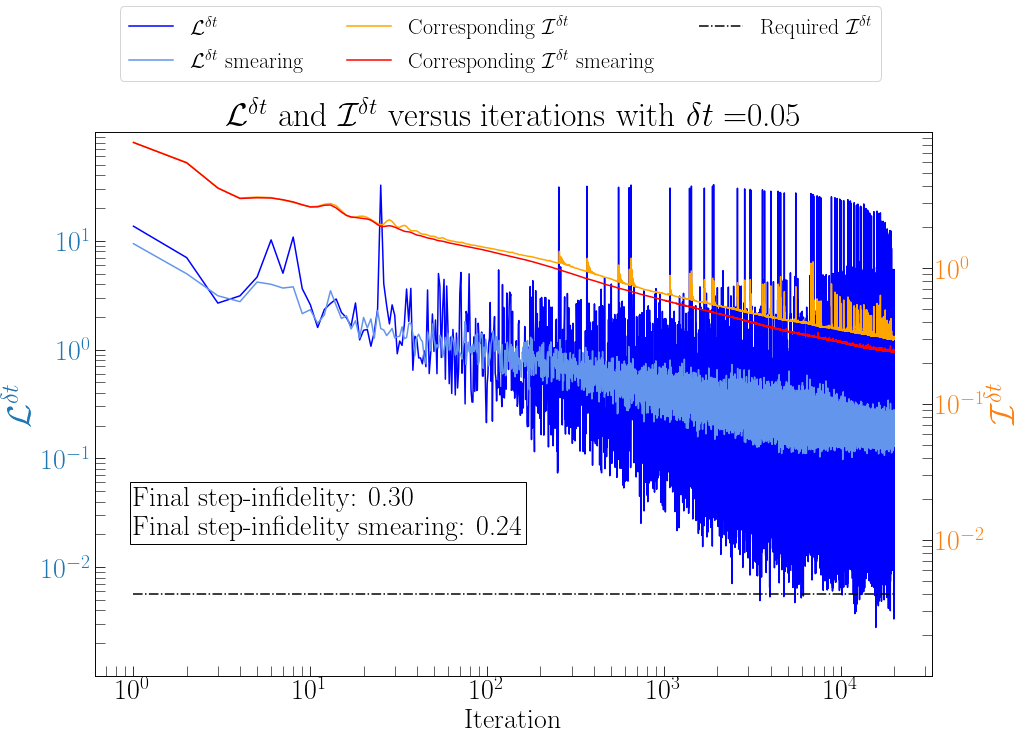

In [115]:
fig, ax1 = plt.subplots()
fig.set_size_inches(15, 10)
color = 'tab:blue'
ax1.set_xlabel('Iteration', fontsize = 28)
ax1.set_ylabel(r'$\mathcal{L}^{\delta t}$', color = color, fontsize = 35)
ax1.plot(np.arange(len(loss_values_Adam))+1, jnp.array(loss_values_Adam)/dt**2, color = "blue", label = '$\mathcal{L}^{\delta t}$')
ax1.plot(np.arange(len(loss_values_Adam_smearing))+1, jnp.array(loss_values_Adam_smearing)/dt**2, color = "cornflowerblue", label = '$\mathcal{L}^{\delta t}$ smearing')

ax1.tick_params(axis ='y', labelcolor = color, which = "both", direction = 'in', length = 10)
ax1.tick_params(axis ='x', which = "both", direction = 'in', length = 10)

ax1.set_yscale('log')
ax1.set_xscale('log')
#ax1.grid(which = "major")

color = 'tab:orange'
ax2 = ax1.twinx()
ax2.set_ylabel(r'$\mathcal{I}^{\delta t}$', color = color, fontsize = 35)
ax2.plot(np.arange(len(infidelity_values_Adam))+1, jnp.array(infidelity_values_Adam)/dt**2, color = "orange", label = r'Corresponding $\mathcal{I}^{\delta t}$')
ax2.plot(np.arange(len(infidelity_values_Adam_smearing))+1, jnp.array(infidelity_values_Adam_smearing)/dt**2, color = "red", label = r'Corresponding $\mathcal{I}^{\delta t}$ smearing')
ax2.hlines(tol/dt**2, 1, max(len(infidelity_values_Adam_smearing), len(infidelity_values_Adam))+50, color = "black", linestyle = "dashdot", label = r"Required $\mathcal{I}^{\delta t}$")

ax2.tick_params(axis ='y', labelcolor = color, which = "both", direction = 'in', length = 10)
ax2.set_yscale('log')
ax2.set_xscale('log')

max1 = jnp.max(jnp.array(infidelity_values_Adam)/dt**2)
max2 = jnp.max(jnp.array(infidelity_values_Adam_smearing)/dt**2)
max3 = jnp.max(jnp.array(loss_values_Adam)/dt**2)
max4 = jnp.max(jnp.array(loss_values_Adam_smearing)/dt**2)

upper_bound = max(max1, max2, max3, max4)

#ax2.grid(which = "major")

fig.legend(loc='upper center', bbox_to_anchor=(0.5, 1.07), fontsize = 22, ncol = 3)

ax1.set_yticks(np.logspace(-2, 1, 4))
ax2.set_yticks(np.logspace(-2, 0, 3))

ax1.set_ylim([1e-3, 1e2])
ax2.set_ylim([1e-3, 1e1])

ax1.text(1, 0.2e-1, f' Final step-infidelity: {infidelity_values_Adam[-1]/dt**2:.2f} \n  Final step-infidelity smearing: {infidelity_values_Adam_smearing[-1]/dt**2:.2f}', bbox = {"fc" : "white"}, backgroundcolor = "white")
#ax2.text(440, 1.2e-1, f' \n Final step-infidelity: {infidelity_values_Adam[-1]/dt**2} \n Final step-infidelity smearing: {infidelity_values_Adam_smearing[-1]/dt**2}  ', bbox = {"fc" : "white"}, backgroundcolor = "white")

ax1.set_title(r"$\mathcal{L}^{\delta t}$ and $\mathcal{I}^{\delta t}$ versus iterations with $\delta t = $"+str(dt))
fig.savefig("dt_optimization_zero_L.jpeg", bbox_inches="tight")

In [41]:
print("The initial infidelity is: ", infidelity_values_Adam[0]/dt**2)
print("The final infidelity is: ", infidelity_values_Adam[-1]/dt**2)

print("\n")

print("The initial infidelity with smearing is: ", infidelity_values_Adam_smearing[0]/dt**2)
print("The final infidelity with smearing is: ", infidelity_values_Adam_smearing[-1]/dt**2)

The initial infidelity is:  8.389781887756207
The final infidelity is:  0.3011084181875123


The initial infidelity with smearing is:  8.389781887756207
The final infidelity with smearing is:  0.24218355101197625


In [42]:
#np.savetxt("loss_values_lin.txt", dict_zeros["loss_values_Adam"][0])
#np.savetxt("infidelity_values_lin.txt", dict_zeros["infidelity_values_Adam"][0])

#np.savetxt("loss_values_smearing_lin.txt", dict_zeros["loss_values_Adam_smearing"][0])
#np.savetxt("infidelity_values_smearing_lin.txt", dict_zeros["infidelity_values_Adam_smearing"][0])


In [39]:
#np.savetxt("loss_values_log.txt", dict_zeros["loss_values_Adam"][1])
#np.savetxt("infidelity_values_log.txt", dict_zeros["infidelity_values_Adam"][1])

#np.savetxt("loss_values_smearing_log.txt", dict_zeros["loss_values_Adam_smearing"][1])
#np.savetxt("infidelity_values_smearing_log.txt", dict_zeros["infidelity_values_Adam_smearing"][1])


In [44]:
#np.savetxt("loss_values.txt", dict_zeros["loss_values_Adam"][1])
#np.savetxt("infidelity_values.txt", dict_zeros["infidelity_values_Adam"][1])

#np.savetxt("loss_values_smearing.txt", dict_zeros["loss_values_Adam_smearing"][1])
#np.savetxt("infidelity_values_smearing.txt", dict_zeros["infidelity_values_Adam_smearing"][1])


## Noise in the initialization

In [45]:
noise = 0.1*np.random.randn(p.size)

In [118]:
dict_zeros["loss_values_Adam_noise"].append(np.loadtxt("loss_values_noise.txt"))
dict_zeros["infidelity_values_Adam_noise"].append(np.loadtxt("infidelity_values_noise.txt"))


## $\mathcal{L}$

In [119]:
lr = 0.001
tol = 1e-5

In [47]:
final_iter, p_prime, loss_values_Adam, infidelity_values_Adam = optimize_Adam(p, p+noise, estimate_L2_psi, dt, H, lr = lr, tol = tol, n_iter_max = int(1.5*n_iter_max), beta1=0.9, beta2=0.999, epsilon=1e-8, Ns = Ns, pool_of_samples = pool_of_samples_extended, method = "sampling")
dict_zeros["loss_values_Adam_noise"].append(loss_values_Adam)
dict_zeros["infidelity_values_Adam_noise"].append(infidelity_values_Adam)
dict_zeros["final_iter_noise"].append(final_iter)


Iteration number:  0
Iteration number:  50
Iteration number:  100
Iteration number:  150
Iteration number:  200
Iteration number:  250
Iteration number:  300
Iteration number:  350
Iteration number:  400
Iteration number:  450
Iteration number:  500
Iteration number:  550
Iteration number:  600
Iteration number:  650
Iteration number:  700
Iteration number:  750
Iteration number:  800
Iteration number:  850
Iteration number:  900
Iteration number:  950
Iteration number:  1000
Iteration number:  1050
Iteration number:  1100
Iteration number:  1150
Iteration number:  1200
Iteration number:  1250
Iteration number:  1300
Iteration number:  1350
Iteration number:  1400
Iteration number:  1450
Iteration number:  1500
Iteration number:  1550
Iteration number:  1600
Iteration number:  1650
Iteration number:  1700
Iteration number:  1750
Iteration number:  1800
Iteration number:  1850
Iteration number:  1900
Iteration number:  1950
Iteration number:  2000
Iteration number:  2050
Iteration numbe

In [120]:
loss_values_Adam = dict_zeros["loss_values_Adam"][1]
infidelity_values_Adam = dict_zeros["infidelity_values_Adam"][1]
#final_iter = dict_zeros["final_iter"][1]

loss_values_Adam_noise = dict_zeros["loss_values_Adam_noise"][0]
infidelity_values_Adam_noise = dict_zeros["infidelity_values_Adam_noise"][0]
#final_iter_noise = dict_zeros["final_iter"][1]



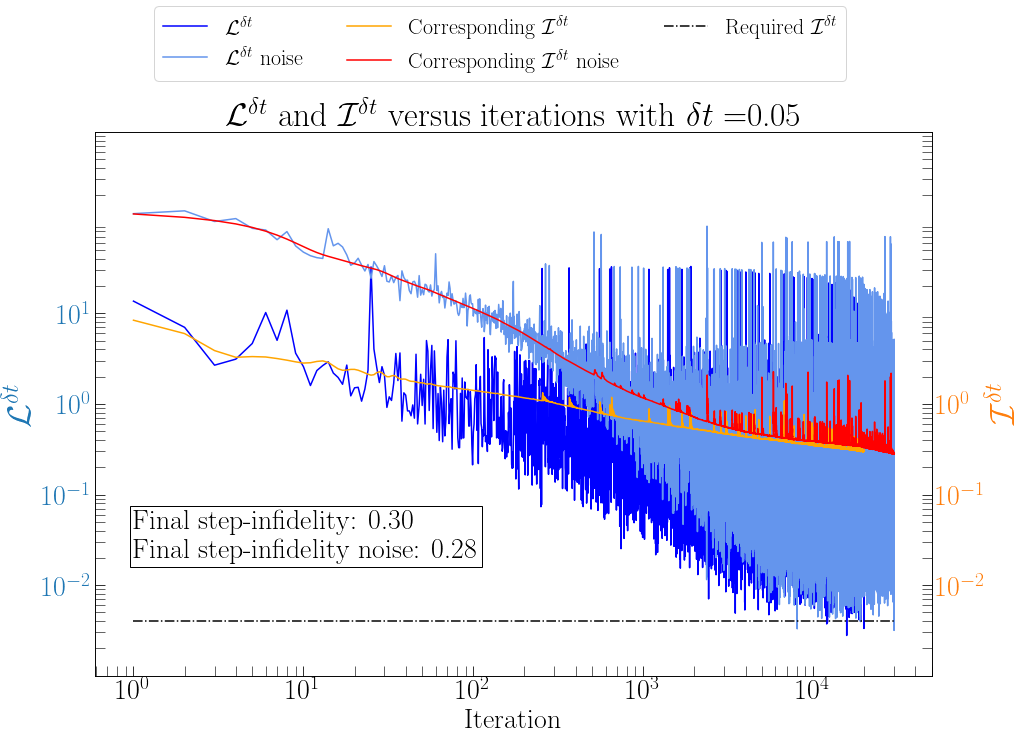

In [124]:
fig, ax1 = plt.subplots()
fig.set_size_inches(15, 10)
color = 'tab:blue'
ax1.set_xlabel('Iteration', fontsize = 28)
ax1.set_ylabel(r'$\mathcal{L}^{\delta t}$', color = color, fontsize = 35)
ax1.plot(np.arange(len(loss_values_Adam))+1, jnp.array(loss_values_Adam)/dt**2, color = "blue", label = '$\mathcal{L}^{\delta t}$')
ax1.plot(np.arange(len(loss_values_Adam_noise))+1, jnp.array(loss_values_Adam_noise)/dt**2, color = "cornflowerblue", label = '$\mathcal{L}^{\delta t}$ noise')

ax1.tick_params(axis ='y', labelcolor = color, which = "both", direction = 'in', length = 10)
ax1.tick_params(axis ='x', which = "both", direction = 'in', length = 10)

ax1.set_yscale('log')
ax1.set_xscale('log')
#ax1.grid(which = "major")

color = 'tab:orange'
ax2 = ax1.twinx()
ax2.set_ylabel(r'$\mathcal{I}^{\delta t}$', color = color, fontsize = 35)
ax2.plot(np.arange(len(infidelity_values_Adam))+1, jnp.array(infidelity_values_Adam)/dt**2, color = "orange", label = r'Corresponding $\mathcal{I}^{\delta t}$')
ax2.plot(np.arange(len(infidelity_values_Adam_noise))+1, jnp.array(infidelity_values_Adam_noise)/dt**2, color = "red", label = r'Corresponding $\mathcal{I}^{\delta t}$ noise')
ax2.hlines(tol/dt**2, 1, max(len(infidelity_values_Adam_noise), len(infidelity_values_Adam))+50, color = "black", linestyle = "dashdot", label = r"Required $\mathcal{I}^{\delta t}$")

ax2.tick_params(axis ='y', labelcolor = color, which = "both", direction = 'in', length = 10)
ax2.set_yscale('log')
ax2.set_xscale('log')

max1 = jnp.max(jnp.array(infidelity_values_Adam)/dt**2)
max2 = jnp.max(jnp.array(infidelity_values_Adam_noise)/dt**2)
max3 = jnp.max(jnp.array(loss_values_Adam)/dt**2)
max4 = jnp.max(jnp.array(loss_values_Adam_noise)/dt**2)

upper_bound = max(max1, max2, max3, max4)

#ax2.grid(which = "major")

fig.legend(loc='upper center', bbox_to_anchor=(0.5, 1.07), fontsize = 22, ncol = 3)

ax1.set_yticks(np.logspace(-2, 1, 4))
ax2.set_yticks(np.logspace(-2, 0, 3))

ax1.set_ylim([1e-3, 1e3])
ax2.set_ylim([1e-3, 1e3])

ax1.text(1, 0.2e-1, f' Final step-infidelity: {infidelity_values_Adam[-1]/dt**2:.2f} \n  Final step-infidelity noise: {infidelity_values_Adam_noise[-1]/dt**2:.2f}', bbox = {"fc" : "white"}, backgroundcolor = "white")

ax1.set_title(r"$\mathcal{L}^{\delta t}$ and $\mathcal{I}^{\delta t}$ versus iterations with $\delta t = $"+str(dt))
fig.savefig("dt_optimization_zero_L_noise.jpeg", bbox_inches="tight")

In [50]:
print("The initial infidelity is: ", infidelity_values_Adam[0]/dt**2)
print("The final infidelity is: ", infidelity_values_Adam[-1]/dt**2)

print("\n")

print("The initial infidelity with noise is: ", infidelity_values_Adam_noise[0]/dt**2)
print("The final infidelity with noise is: ", infidelity_values_Adam_noise[-1]/dt**2)

The initial infidelity is:  8.389781887756207
The final infidelity is:  0.3011084181875123


The initial infidelity with noise is:  124.93553810975617
The final infidelity with noise is:  0.2826069599584535


In [45]:
np.savetxt("loss_values_lin.txt", dict_zeros["loss_values_Adam"][0])
np.savetxt("infidelity_values_lin.txt", dict_zeros["infidelity_values_Adam"][0])

np.savetxt("loss_values_noise_lin.txt", dict_zeros["loss_values_Adam_noise"][0])
np.savetxt("infidelity_values_noise_lin.txt", dict_zeros["infidelity_values_Adam_noise"][0])


In [52]:
np.savetxt("loss_values_noise.txt", dict_zeros["loss_values_Adam_noise"][0])
np.savetxt("infidelity_values_noise.txt", dict_zeros["infidelity_values_Adam_noise"][0])
